In [21]:
import cv2
from skimage.transform import resize
from os import listdir, walk
from os.path import isfile, join
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

def gray_reshape(directory, new_size = (28,28), gray =False):
    """
    give the list of photos with the correct pixel size you want to 
    downsize. If you want Gray then write True.
    """
    items_resized  =[]
    pictures = []
    labels = []
    mapping = {'plants' : 0,'coins' : 1,'faces' : 2,'cups' : 3,'glasses' : 4,'pens' : 5,'gestures' : 6,'cutlery' : 7,'plates' : 8, 
                'nail_polishes' : 9  ,'shoes' : 10 
                }
    onlyfolders = [f for f in listdir(directory)]
    for idx, folder in enumerate(onlyfolders[1:]):
        pictures = [f for f in listdir(directory + folder) if isfile(join(directory + folder , f))]
        for idx, picture in enumerate(pictures):
            item = cv2.imread(directory + folder +'/'+ picture )
            labels.append(mapping[folder])
            
            if gray == True:
                item_gray = cv2.cvtColor(item, cv2.COLOR_BGR2GRAY)
                item_resized_gray = resize(item_gray, new_size)
                items_resized.append(item_resized_gray)
            else:
                item_resized_colored = resize(item, new_size)
                items_resized.append(item_resized_colored)
    return items_resized, labels

In [22]:
onlyfolders = [f for f in listdir('../output/')]
onlyfolders

['.DS_Store',
 'plants',
 'coins',
 'glasses',
 'pens',
 'gestures',
 'cutlery',
 'plates',
 'nail_polishes',
 'shoes',
 'cups',
 'faces']

In [23]:
X , y = gray_reshape('../output/', new_size = (160,160), gray =False);

#plt.imshow(X[8],cmap='Greys')
# Model / data parameters
num_classes = len(np.unique(y))
input_shape = (160, 160, 3)
# shuffle the data

shuffler = np.random.permutation(len(X))
X = np.array(X)
y = np.array(y)
X = X[shuffler]
y = y[shuffler]



In [24]:
# the data, split between train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
# Scale images to the [0, 1] range
#### Normalise


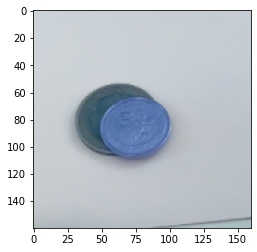

In [25]:
plt.imshow(X[799],cmap='Greys')

In [26]:
# Always always check shapes! 
X_train.shape, X_test.shape

((1042, 160, 160, 3), (184, 160, 160, 3))

In [27]:
x_train = X_train.astype("float32") / 255
x_test = X_test.astype("float32") / 255

# one hot encoder

y_train = keras.utils.to_categorical(y_train, num_classes)

y_test = keras.utils.to_categorical(y_test, num_classes)



In [28]:
# define the keras model.    the kernel size is the window that checks geometries: can be (3,3), (5,5), (7,7)
# Always clear the session!
K.clear_session()
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(5, 5), activation="relu"),   # number of neurons:  must be multiples of 2. good technique to start eith 8 and then we increase in the insede layers.
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.1),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
# model summary table
model.summary()

# define the batch size and number of epochs
batch_size = 5
epochs = 200




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 156, 156, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 78, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 76, 76, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 46208)             0         
                                                                 
 dropout (Dropout)           (None, 46208)             0

In [20]:
# complile and define eval metric
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])



In [21]:
# fit the model
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/200
188/188 [==============================] - 30s 157ms/step - loss: 2.2984 - accuracy: 0.1889 - val_loss: 2.2717 - val_accuracy: 0.2000
Epoch 2/200
188/188 [==============================] - 32s 170ms/step - loss: 2.1287 - accuracy: 0.2241 - val_loss: 1.8801 - val_accuracy: 0.4286
Epoch 3/200
188/188 [==============================] - 33s 176ms/step - loss: 1.5433 - accuracy: 0.4899 - val_loss: 1.2620 - val_accuracy: 0.4952
Epoch 4/200
188/188 [==============================] - 28s 151ms/step - loss: 1.1938 - accuracy: 0.6265 - val_loss: 1.0213 - val_accuracy: 0.6476
Epoch 5/200
188/188 [==============================] - 27s 142ms/step - loss: 1.0212 - accuracy: 0.6606 - val_loss: 0.9318 - val_accuracy: 0.6952
Epoch 6/200
188/188 [==============================] - 26s 137ms/step - loss: 0.9137 - accuracy: 0.7044 - val_loss: 0.9633 - val_accuracy: 0.7048
Epoch 7/200
188/188 [==============================] - 26s 138ms/step - loss: 0.7135 - accuracy: 0.7834 - val_loss: 0.7720 -

In [22]:
model.save("model_MNIST_2.h5")
# here you can stop your notebook
# moons_model = load_model("model_MNIST.h5")
# moons_model.summary()

In [8]:
##### Load model if needed
from tensorflow.keras.models import load_model
model = load_model("model_MNIST_2.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 156, 156, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 78, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 76, 76, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 46208)             0         
                                                                 
 dropout (Dropout)           (None, 46208)             0

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5292601585388184
Test accuracy: 0.9402173757553101


print(ynew[1])
print(y_test[1])

In [10]:
mapping = {'plants' : 0,'coins' : 1,'faces' : 2,'cups' : 3,'glasses' : 4,'pens' : 5,'gestures' : 6,'cutlery' : 7,'plates' : 8, 
             'nail_polishes' : 9  ,'shoes' : 10 
             }
ynew = model.predict(x_test)
# show the inputs and predicted outputs
for idx, value in enumerate(ynew):
    print(f'With {np.max(value)} probability the model predicts that it is a {list(mapping)[np.where(value == np.max(value))[0][0]]}.')#
    print(f'The item is {list(mapping)[np.where(y_test[idx] == np.max(y_test[idx]))[0][0]]}.')
    


With 0.9996676445007324 probability the model predicts that it is a gestures.
The item is gestures.
With 0.9918699264526367 probability the model predicts that it is a shoes.
The item is plants.
With 1.0 probability the model predicts that it is a coins.
The item is coins.
With 0.9999979734420776 probability the model predicts that it is a gestures.
The item is gestures.
With 0.999934196472168 probability the model predicts that it is a cutlery.
The item is cutlery.
With 0.9999986886978149 probability the model predicts that it is a coins.
The item is coins.
With 0.9999988079071045 probability the model predicts that it is a gestures.
The item is gestures.
With 0.9999454021453857 probability the model predicts that it is a shoes.
The item is shoes.
With 0.9999159574508667 probability the model predicts that it is a gestures.
The item is gestures.
With 1.0 probability the model predicts that it is a faces.
The item is faces.
With 0.9999998807907104 probability the model predicts that it

In [261]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)